# Twitch Friendship Network

First, install and import the proper python libraries. If your having trouble try adding '!' before the pip, like so '!pip'

In [6]:
pip install twitchAPI
pip install networkx[default]


The following command must be run outside of the IPython shell:

    $ pip install twitchAPI

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [7]:
from twitchAPI.twitch import Twitch
from pprint import pprint
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
api_key = '45smruax3qg6qh72lnf9ykcoqm3cm5'
oauth = 'jymak5hh67w2l9cnvmq054letjzera'
backup_key = 'txs58of1olyox4slhk1l7pk70f3iys'
backup_auth = 'cz4lwheyynrl8s98k0ypk25aumj577'

Then set the API key and authentication, and print a test to make sure that it works. If it doesn't, change the api_key and oauth variables to the backups above.

In [161]:
twitch = Twitch(api_key, oauth)
pprint(twitch.get_users(logins=['serenegrachay']))

{'data': [{'broadcaster_type': '',
           'created_at': '2018-03-07T22:25:20Z',
           'description': 'Gamer. Guinness World Record Holder. Cat Owner.',
           'display_name': 'SereneGrachay',
           'id': '203571765',
           'login': 'serenegrachay',
           'offline_image_url': '',
           'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/7f0ebcd0-1016-4fa0-b3c3-a088e4751c6f-profile_image-300x300.png',
           'type': '',
           'view_count': 951}]}


# Get Nodes Who the User Follows

The getNodesFollows function recursively get the entire list of a user's follows

In [145]:
#twitch.get_users_follows(from_id=203571765)
def getNodesFollows(twitchGetUserFollows): #accepts a call to twitch api to get the users follows from a certain id
    following_ids = [] #Store all ids
    following = twitchGetUserFollows #put data in a variable
    
    for i in range(len(following["data"])): #Goes through the data on the current page, default to 20
        following_ids.append(following['data'][i]['to_id']) #Appends the user's follows id's
        
        if i == 19 and following['pagination']['cursor'] is not '': #Checks if  there is another page and that we finished current page
            #Merges following_ids array with the array return recursively
            following_ids = following_ids + getNodesFollows(twitch.get_users_follows(after=following['pagination']['cursor'], from_id=203571765))

    return following_ids

In [146]:
following_ids = getNodesFollows(twitch.get_users_follows(from_id=203571765))

# Get User's Follower Nodes

In [147]:
#twitch.get_users_follows(to_id=203571765)
def getNodesFollowers(twitchGetUserFollowers): #accepts a call to twitch api to get the users follows from a certain id
    follower_ids = [] #Store all ids
    followers = twitchGetUserFollowers #put data in a variable
    
    for i in range(len(followers["data"])): #Goes through the data on the current page, default to 20
        follower_ids.append(followers['data'][i]['from_id']) #Appends the user's followers id's
        if i == 19 and followers['pagination']['cursor'] is not '': #Checks if  there is another page and that we finished current page
            #Merges following_ids array with the array return recursively
            follower_ids = follower_ids + getNodesFollowers(twitch.get_users_follows(after=followers['pagination']['cursor'],to_id=203571765))

    return follower_ids

In [157]:
followers = getNodesFollowers(twitch.get_users_follows(to_id=203571765))

### Merge following_ids and followers

In [154]:
all_ids_merge = following_ids + followers #merges the ids of those you follow and who follow you
all_ids_set = set(all_ids_merge) #Gets rid of duplicate ids
all_ids = list(all_ids_set) #makes the set into a list again to allow iterating
all_ids.insert(0, '203571765') #Inserts the source node, which is not automatically added

# Graph Drawing

This method will create the graph, as well as write the nodes in pairs (one following the next) to a csv file

In [172]:
graph = nx.DiGraph()
def realtime_to_Graph():
    for i in range(len(all_ids)):
        for j in range(len(all_ids)):

            if (twitch.get_users_follows(from_id=int(all_ids[i]), to_id=int(all_ids[j]))['data']):
                #print(True)
                #pprint(twitch.get_users_follows(from_id=int(all_ids[i]), to_id=int(all_ids[j])))
                graph.add_edges_from([(i, j)])
                with open('graph.csv', 'a', newline='') as csvfile: 
                    csvwriter = csv.writer(csvfile) 
                    csvwriter.writerow([i, j]) 

In [ ]:
realtime_to_Graph():

This method will create a graph from the given csv file

In [ ]:
graph = nx.DiGraph()
def readCSV_to_Graph():
    with open('graph.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if row:
                #print(row[0],row[1])
                graph.add_edges_from([(row[0], row[1])])

In [ ]:
#readCSV_to_Graph() #Uncomment this if you want to create graph from csv

Finally we plot the graph

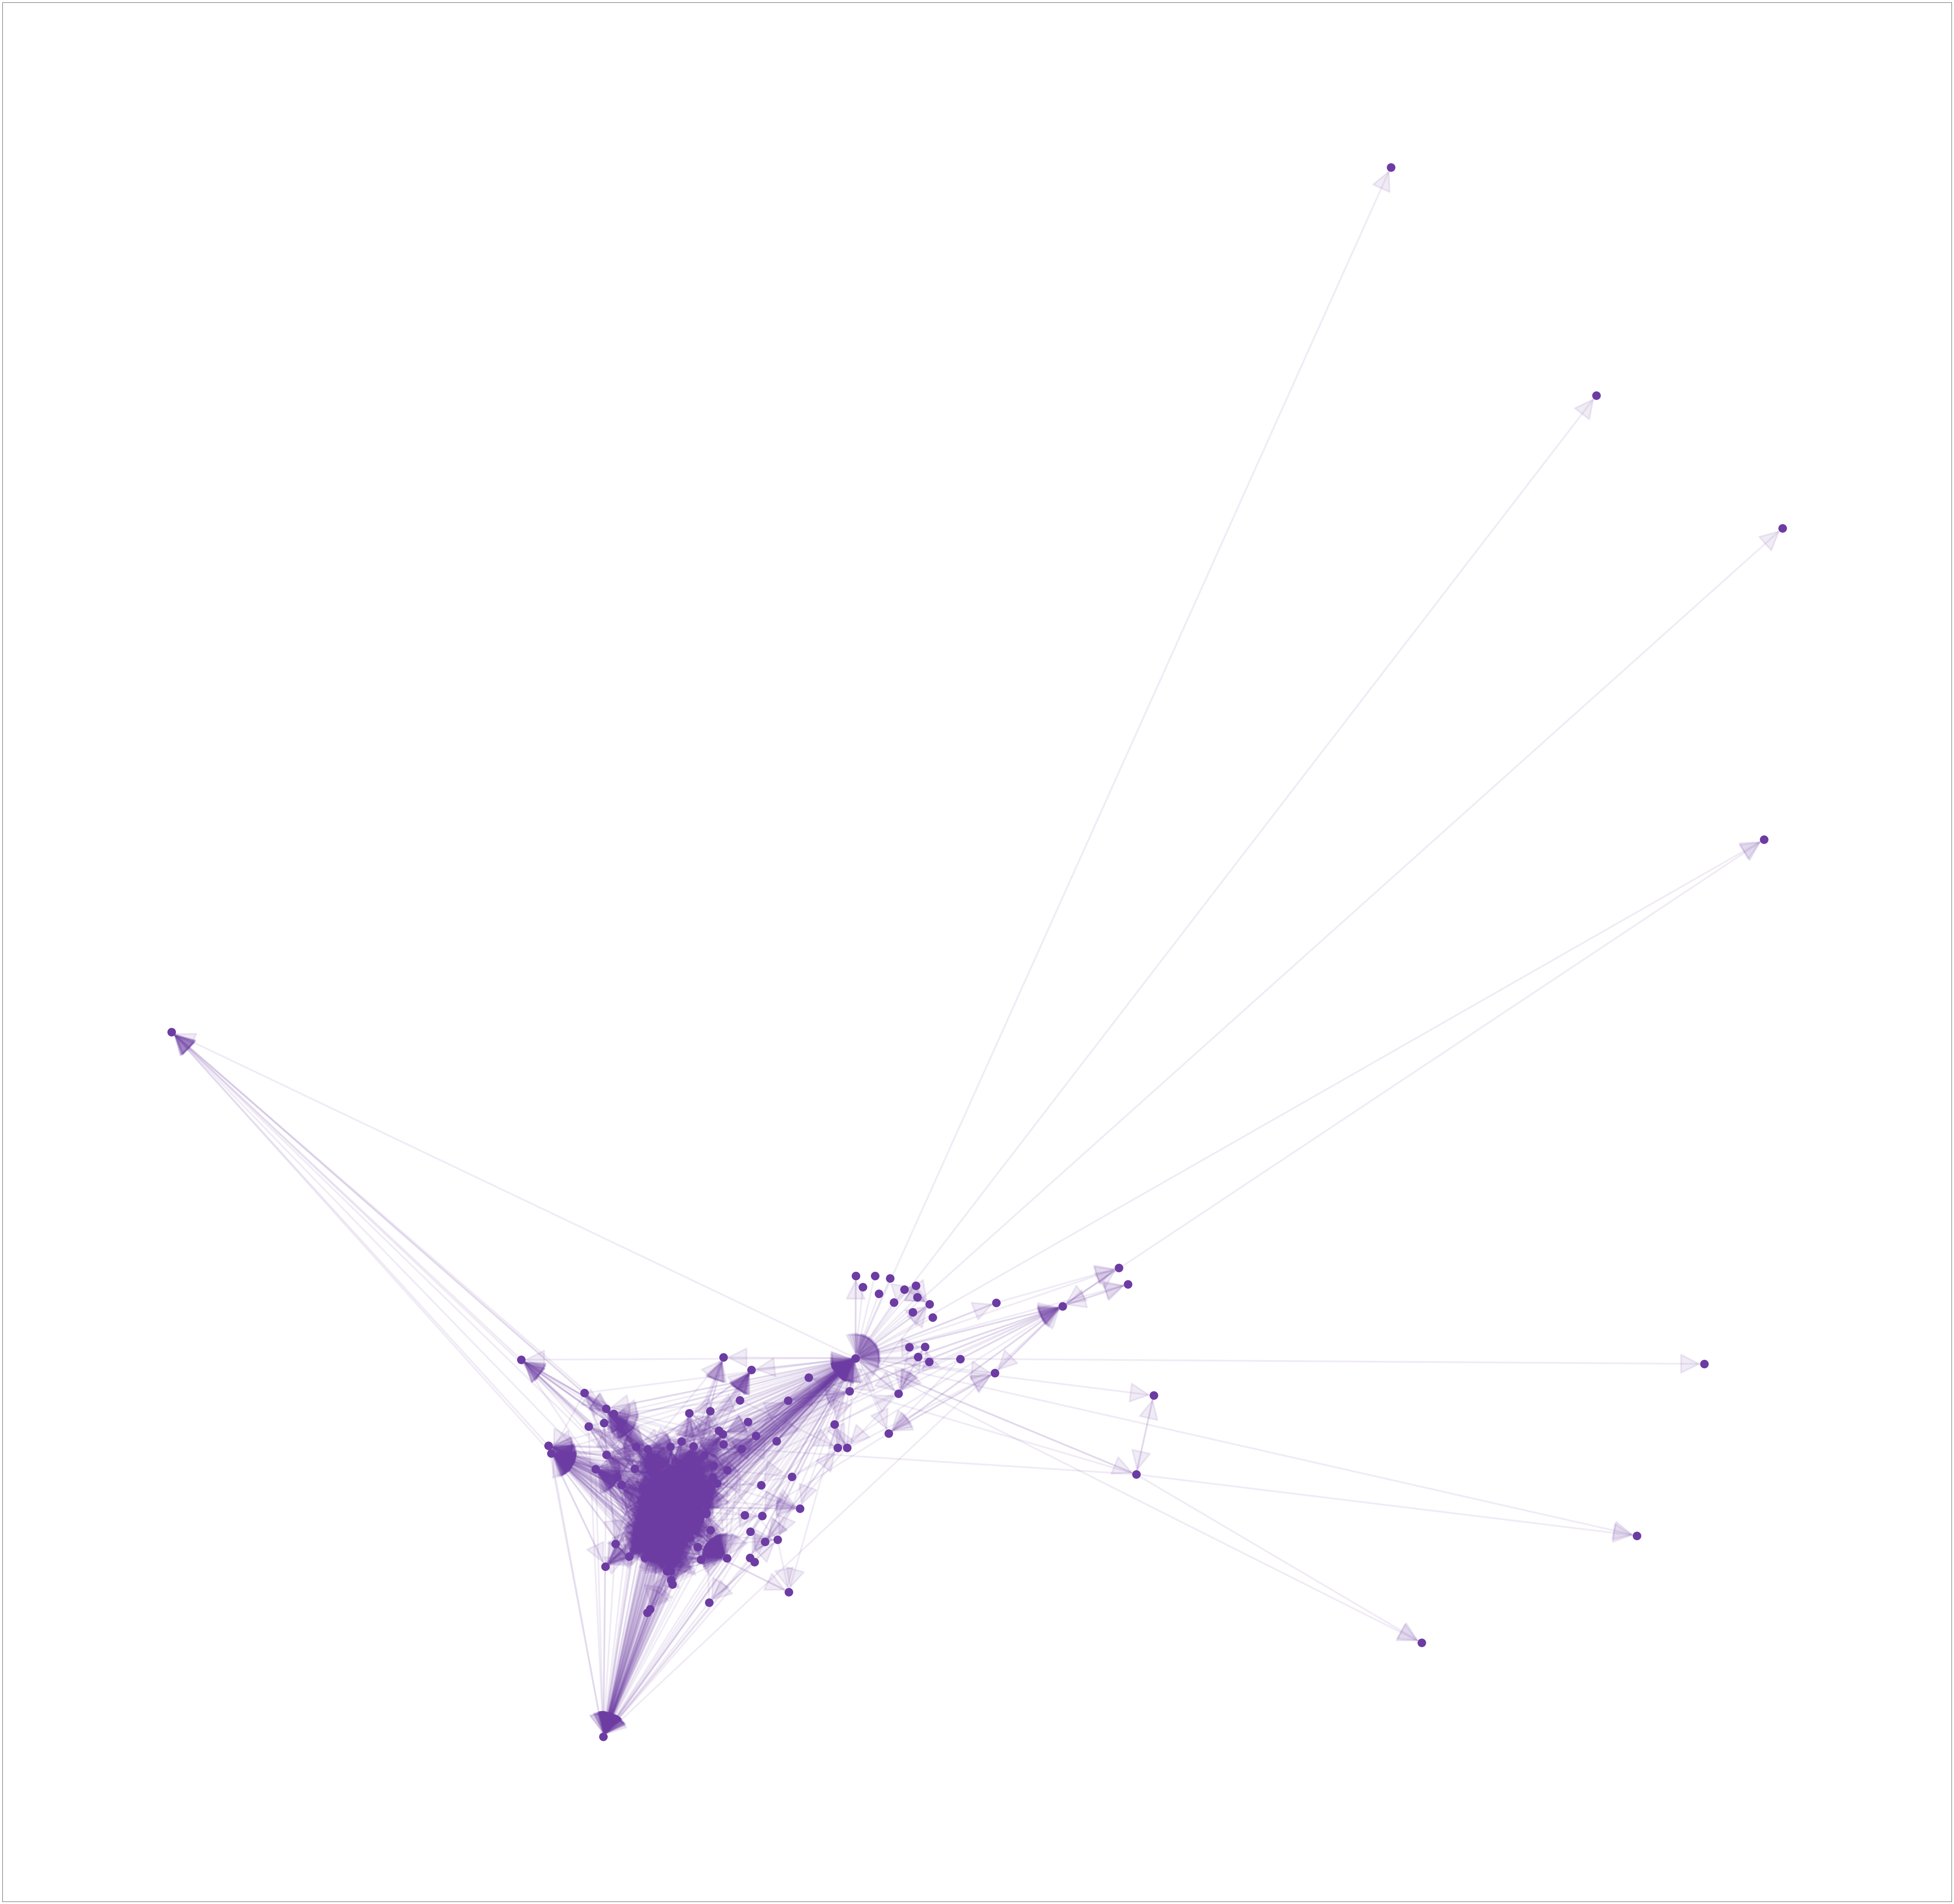

In [201]:
purple = '#6c3ca3'

fig = plt.figure("Friendship Network", figsize=(100, 100))

pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_size=550, node_color=purple)
nx.draw_networkx_edges(graph, pos, width=5, edge_color=purple, alpha=0.1, arrows=True, arrowsize=130)
#nx.draw_networkx_labels(graph, pos, alpha=.4, font_size=40, font_color='r')
plt.savefig('FriendshipNetwork.png')
plt.show()

# Network Measures

Here we plot the degree distribution in a histogram given NetworkX's builtin funtion

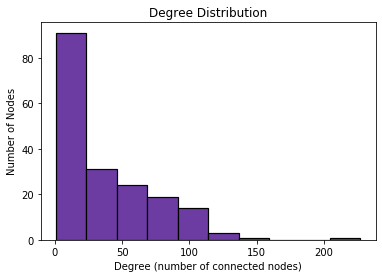

In [210]:
degrees = [graph.degree(n) for n in graph.nodes()]
plt.hist(degrees, edgecolor='black', linewidth=1.2, color=purple)
plt.title('Degree Distribution')
plt.xlabel('Degree (number of connected nodes)')
plt.ylabel('Number of Nodes')
plt.savefig('DegreeDistribution.png')
plt.show()

Here we plot the clustering coefficient in a histogram given NetworkX's builtin funtion

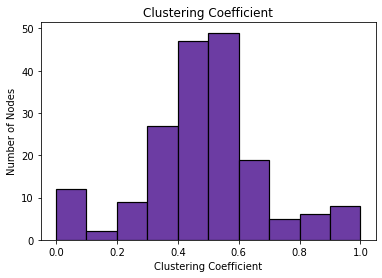

In [211]:
cluster = [nx.clustering(graph, n) for n in graph.nodes()]
plt.hist(cluster, color=purple, edgecolor='black', linewidth=1.2)
plt.title('Clustering Coefficient')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Number of Nodes')
plt.savefig('ClusteringCoefficient.png')
plt.show()

Here we plot the closeness centrality in a histogram given NetworkX's builtin funtion

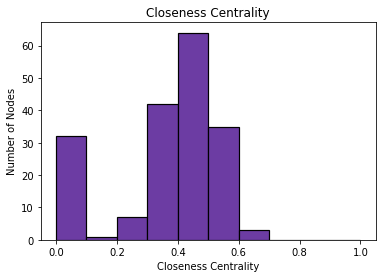

In [213]:
close = [nx.closeness_centrality(graph, n) for n in graph.nodes()]
plt.hist(close, range=[0, 1], color=purple, edgecolor='black', linewidth=1.2)
plt.title('Closeness Centrality')
plt.xlabel('Closeness Centrality')
plt.ylabel('Number of Nodes')
plt.savefig('ClosenessCentrality.png')
plt.show()